In [1]:
using DrWatson

In [2]:
quickactivate(@__DIR__)

In [3]:
projectdir()

"/var/home/tef30/Projects/mine/Covid19"

In [4]:
# ENV["PYTHON"] = "$(ENV['HOME'])/.local/bin/python"

# using Pkg
# Pkg.build("PyCall")

In [5]:
using Covid19

┌ Info: Precompiling Covid19 [1d6b4b23-2965-494f-a811-b0912eb134ac]
└ @ Base loading.jl:1273


In [6]:
using Turing

# Load data

In [7]:
using RData

In [8]:
import DrWatson: datadir

datadir() = projectdir("data", "imperial-report13")
datadir(s...) = projectdir("data", "imperial-report13", s...)

datadir (generic function with 2 methods)

In [9]:
datadir()

"/var/home/tef30/Projects/mine/Covid19/data/imperial-report13"

In [39]:
rdata = load(datadir("processed.rds"));

┌ Warning: Unsupported AltRep SEXP
└ @ RData /var/home/tef30/.julia/packages/RData/7cjT6/src/convert.jl:205


In [40]:
# Convert some misparsed fields
rdata["covariate4"] = Matrix(rdata["covariate4"]);

rdata["N2"] = Int(rdata["N2"]);
rdata["N0"] = Int(rdata["N0"]);

rdata["EpidemicStart"] = Int.(rdata["EpidemicStart"]);

rdata["cases"] = Int.(rdata["cases"]);
rdata["deaths"] = Int.(rdata["deaths"]);

rdata["x"] = []

0-element Array{Any,1}

## Make data a bit more convenient to work with

In [13]:
countries = (
  "Denmark",
  "Italy",
  "Germany",
  "Spain",
  "United_Kingdom",
  "France",
  "Norway",
  "Belgium",
  "Austria", 
  "Sweden",
  "Switzerland",
  "Greece",
  "Portugal",
  "Netherlands"
)
num_countries = length(countries)

# TODO: not sure if either of the below is the correct ordering of the names!
# names_covariates = (
#     "Schools + Universities",
#     "Self-isolating if ill",
#     "Public events",
#     "Lockdown",
#     "Social distancing encouraged"
# )
names_covariates = ("schools_universities", "self_isolating_if_ill", "public_events", "any", "lockdown", "social_distancing_encouraged")

function rename!(d, names::Pair...)
    # check that keys are not yet present before updating `d`
    for k_new in values.(names)
        @assert k_new ∉ keys(d) "$(k_new) already in dictionary"
    end
    
    for (k_old, k_new) in names
        d[k_new] = pop!(d, k_old)
    end
    return d
end


rename! (generic function with 1 method)

In [14]:
# `rdata` is a `DictOfVector` so we convert to a simple `Dict` for simplicity
d = Dict([(k, rdata[k]) for k in keys(rdata)]) # `values(df)` and `keys(df)` have different ordering so DON'T do `Dict(keys(df), values(df))`

# Rename some columns
rename!(
    d,
    "f" => "π", "SI" => "serial_intervals", "pop" => "population",
    "M" => "num_countries", "N0" => "num_impute", "N" => "num_obs_countries",
    "N2" => "num_total_days", "EpidemicStart" => "epidemic_start"
)

# Add some type-information to arrays and replace `-1` with `missing` (as `-1` is supposed to represent, well, missing data)
d["deaths"] = Int.(d["deaths"])
d["deaths"] = replace(d["deaths"], -1 => missing)
d["deaths"] = collect(eachcol(d["deaths"])) # convert into Array of arrays instead of matrix

d["cases"] = Int.(d["cases"])
d["cases"] = replace(d["cases"], -1 => missing)
d["cases"] = collect(eachcol(d["cases"])) # convert into Array of arrays instead of matrix

d["num_total_days"] = Int(d["num_total_days"])
d["num_impute"] = Int(d["num_impute"])
d["num_obs_countries"] = Int.(d["num_obs_countries"])
d["epidemic_start"] = Int.(d["epidemic_start"])
d["population"] = Int.(d["population"])

d["π"] = collect(eachcol(d["π"])) # convert into Array of arrays instead of matrix

# Convert to `Matrix` if some are `DataFrame`
covariates = [Matrix(d["covariate$(i)"]) for i = 1:6]
# Array of matrices, with each element in array corresponding to (time, features)-matrix for a country
covariates = [hcat([covariates[i][:, m] for i = 1:6]...) for m = 1:d["num_countries"]]

data = (; (k => d[String(k)] for k in [:num_countries, :num_impute, :num_obs_countries, :num_total_days, :cases, :deaths, :π, :epidemic_start, :population, :serial_intervals])...)
data = merge(data, (covariates = covariates, ));

In [15]:
data.num_countries

14

# Trying out the model

In [106]:
m = ImperialReport13.model_v2(
    data.num_countries,
    data.num_impute,
    data.num_obs_countries,
    data.num_total_days,
    data.cases,
    data.deaths,
    data.π,
    data.covariates,
    data.epidemic_start,
    data.population,
    data.serial_intervals
);

In [107]:
chain_prior = sample(m, Turing.Inference.PriorSampler(), 10_000);

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:50


In [108]:
chain_prior

Object of type Chains, with data of type 10000×52×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
internals         = lp
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ[1], μ[2], μ[3], μ[4], μ[5], μ[6], μ[7], μ[8], μ[9], μ[10], μ[11], μ[12], μ[13], μ[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters     mean      std  naive_se    mcse         ess   r_hat
  ─────────────  ───────  ───────  ────────  ──────  ──────────  ──────
   ifr_noise[1]   1.0000   0.0994    0.0010  0.0009   9790.2861  1.0000
   ifr_noise[2]   1.0017   0.0992    0.0010  0.0011  10328.2996  

In [19]:
?NUTS

search: NUTS ANUTS DynamicNUTS ncodeunits num_countries InteractiveUtils



```
NUTS(n_adapts::Int, δ::Float64; max_depth::Int=5, Δ_max::Float64=1000.0, ϵ::Float64=0.0)
```

No-U-Turn Sampler (NUTS) sampler.

Usage:

```julia
NUTS()            # Use default NUTS configuration. 
NUTS(1000, 0.65)  # Use 1000 adaption steps, and target accept ratio 0.65.
```

Arguments:

  * `n_adapts::Int` : The number of samples to use with adaptation.
  * `δ::Float64` : Target acceptance rate for dual averaging.
  * `max_depth::Float64` : Maximum doubling tree depth.
  * `Δ_max::Float64` : Maximum divergence during doubling tree.
  * `ϵ::Float64` : Inital step size; 0 means automatically searching using a heuristic procedure.


In [128]:
params = (
    warmup = 100,
    steps = 200,
    model = "imperial-report13-v2-fixed"
)

(warmup = 100, steps = 200, model = "imperial-report13-v2-fixed")

In [23]:
# chain = read(savename("chains", params, "jls"), Chains);

In [129]:
chain = sample(m, NUTS(params.warmup, 0.95; max_depth=10), params.steps + params.warmup);
write(savename("chains", params, "jls"), chain)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /var/home/tef30/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /var/home/tef30/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC /var/home/tef30/.julia/packages/AdvancedHMC/WJCQA/src/hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.003125
└ @ Turing.Inference /var/home/tef30/.julia/packages/Turing/JnBpk/src/inference/hmc.jl:556
Sampling: 100%|█████████████████████████████████████████| Time: 2:23:38


In [130]:
chain

Object of type Chains, with data of type 200×63×1 Array{Float64,3}

Iterations        = 1:200
Thinning interval = 1
Chains            = 1
Samples per chain = 200
internals         = acceptance_rate, hamiltonian_energy, hamiltonian_energy_error, is_accept, log_density, lp, max_hamiltonian_energy_error, n_steps, nom_step_size, numerical_error, step_size, tree_depth
parameters        = ifr_noise[1], ifr_noise[2], ifr_noise[3], ifr_noise[4], ifr_noise[5], ifr_noise[6], ifr_noise[7], ifr_noise[8], ifr_noise[9], ifr_noise[10], ifr_noise[11], ifr_noise[12], ifr_noise[13], ifr_noise[14], y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14], α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6], κ, μ[1], μ[2], μ[3], μ[4], μ[5], μ[6], μ[7], μ[8], μ[9], μ[10], μ[11], μ[12], μ[13], μ[14], τ, ϕ

2-element Array{ChainDataFrame,1}

Summary Statistics
     parameters      mean       std  naive_se     mcse       ess   r_hat
  ─────────────  ────────  ──────

In [131]:
mean(chain)

Mean
     parameters      mean
  ─────────────  ────────
   ifr_noise[1]    0.9965
   ifr_noise[2]    0.9876
   ifr_noise[3]    0.9884
   ifr_noise[4]    0.9817
   ifr_noise[5]    1.0022
   ifr_noise[6]    1.0017
   ifr_noise[7]    1.0094
   ifr_noise[8]    1.0100
   ifr_noise[9]    0.9962
  ifr_noise[10]    1.0242
  ifr_noise[11]    1.0053
  ifr_noise[12]    1.0092
  ifr_noise[13]    1.0132
  ifr_noise[14]    0.9976
           y[1]  106.5155
           y[2]   50.0889
           y[3]  121.1581
           y[4]   32.5631
           y[5]   89.0113
           y[6]   89.1963
           y[7]  113.0131
           y[8]   82.4601
           y[9]   59.7110
          y[10]  252.2960
          y[11]  154.7104
          y[12]   76.9049
          y[13]   93.4711
          y[14]  107.1203
      α_hier[1]    0.2823
      α_hier[2]    0.7858
      α_hier[3]    0.4547
      α_hier[4]    1.7494
      α_hier[5]    0.1515
      α_hier[6]    0.4083
              κ    1.9786
           μ[1]    1.4806
       

# Predictions 

In [132]:
"""
    generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)

Executes `m` for each of the samples in `c` and returns an array of the values returned by the `m` for each sample.

## Examples
Often you might have additional quantities computed inside the model that you want to inspect, e.g.
```julia
@model demo(x) = begin
    # sample and observe
    θ ~ Prior()
    x ~ Likelihood()

    return interesting_quantity(θ, x)
end

m = demo(data)
chain = sample(m, alg, n)

# To inspect the `interesting_quantity(θ, x)` where `θ` is replaced by samples from the posterior/`chain`:
generated_quantities(m, chain)
```
"""
function generated_quantities(m::Turing.Model, c::Turing.MCMCChains.Chains)
    varinfo = Turing.DynamicPPL.VarInfo(m)

    map(1:length(c)) do i
        Turing.DynamicPPL._setval!(varinfo, c[i])
        m(varinfo)
    end
end


generated_quantities

# Visualization

In [133]:
using Plots, StatsPlots
pyplot()

Plots.PyPlotBackend()

In [134]:
function plot_confidence!(p::Plots.Plot, data; label="", kwargs...)
    intervals = [0.025, 0.25, 0.5, 0.75, 0.975]
    
    qs = [quantile(v, intervals) for v in eachrow(data)]
    llq, lq, mq, uq, uuq = (eachrow(hcat(qs...))..., )
    plot!(mq, ribbon=(mq - llq, uuq - mq), linewidth=0, label="$label (95% quantiles)", kwargs...)
    plot!(mq, ribbon=(mq - lq, uq - mq), linewidth=0, label="$label (50% quantiles)", kwargs...)

    return p
end

plot_confidence(data; kwargs...) = plot_confidence!(plot(), data; kwargs...)

plot_confidence (generic function with 1 method)

In [109]:
# HACK: eeehm this could be nicer:)

res = generated_quantities(m, chain_prior)
prediction_prior = [x[1] for x in res];
expected_deaths_prior = [x[2] for x in res];
Rₜ_prior = [x[3] for x in res];

function country_prediction_prior_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    Rₜ_chain_country = hcat([Rₜ_prior[t][country_idx] for t = 1:length(chain_prior)]...)
    predictions_country = hcat([prediction_prior[t][country_idx] for t = 1:length(chain_prior)]...)

    p1 = bar(replace(data.deaths[country_idx], missing => -1.), label="$(countries[country_idx])")
    title!("Daily deaths")
    vline!([data.epidemic_start[country_idx]], label="epidemic start", linewidth=2)
    vline!([data.num_obs_countries[country_idx]], label="end of observations", linewidth=2)

    p2 = plot_confidence(e_deaths_country; label = "$(countries[country_idx])")
    title!("Daily deaths (pred)")

    p3 = plot_confidence(Rₜ_chain_country; label = "$(countries[country_idx])")
    for (c_idx, c_time) in enumerate(findfirst.(==(1), eachcol(data.covariates[country_idx])))
        if c_time !== nothing
            # c_name = names(covariates)[2:end][c_idx]
            c_name = names_covariates[c_idx]
            vline!([c_time], label=c_name)
        end
    end
    title!("Rₜ")

    # p3 = bar(replace(data.cases[country_idx], missing => -1.), label="$(countries[country_idx])")
    # title!("Daily cases")

    p4 = plot_confidence(predictions_country; label = "$(countries[country_idx])")
    title!("Daily cases (pred)")

    vals = cumsum(e_deaths_country; dims = 1)
    p5 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.deaths[country_idx]), label="observed")
    title!("Deaths (pred)")

    vals = cumsum(predictions_country; dims = 1)
    p6 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.cases[country_idx]), label="observed")
    title!("Cases (pred)")

    plot(p1, p3, p2, p4, p5, p6, layout=(6, 1), size=(900, 1200))
end

country_prediction_prior_plot (generic function with 1 method)

In [166]:
res = generated_quantities(m, chain)
prediction_chain = [x[1] for x in res];
expected_deaths_chain = [x[2] for x in res];
Rₜ_chain = [x[3] for x in res];

function country_prediction_plot(country_idx)
    e_deaths_country = hcat([expected_deaths_chain[t][country_idx] for t = 1:length(chain)]...)
    Rₜ_chain_country = hcat([Rₜ_chain[t][country_idx] for t = 1:length(chain)]...)
    predictions_country = hcat([prediction_chain[t][country_idx] for t = 1:length(chain)]...)

    p1 = bar(replace(data.deaths[country_idx], missing => -1.), label="$(countries[country_idx])")
    title!("Daily deaths")
    vline!([data.epidemic_start[country_idx]], label="epidemic start", linewidth=2)
    vline!([data.num_obs_countries[country_idx]], label="end of observations", linewidth=2)

    p2 = plot_confidence(e_deaths_country; label = "$(countries[country_idx])")
    title!("Daily deaths (pred)")

    p3 = plot_confidence(Rₜ_chain_country; label = "$(countries[country_idx])")
    for (c_idx, c_time) in enumerate(findfirst.(==(1), eachcol(data.covariates[country_idx])))
        if c_time !== nothing
            # c_name = names(covariates)[2:end][c_idx]
            c_name = names_covariates[c_idx]
            vline!([c_time], label=c_name)
        end
    end
    title!("Rₜ")

    # p3 = bar(replace(data.cases[country_idx], missing => -1.), label="$(countries[country_idx])")
    # title!("Daily cases")

    p4 = plot_confidence(predictions_country; label = "$(countries[country_idx])")
    title!("Daily cases (pred)")

    vals = cumsum(e_deaths_country; dims = 1)
    p5 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.deaths[country_idx]), label="observed")
    title!("Deaths (pred)")

    vals = cumsum(predictions_country; dims = 1)
    p6 = plot_confidence(vals; label = "$(countries[country_idx])")
    plot!(cumsum(data.cases[country_idx]), label="observed")
    title!("Cases (pred)")

    plot(p1, p3, p2, p4, p5, p6, layout=(6, 1), size=(900, 1200))
end

country_prediction_plot (generic function with 1 method)

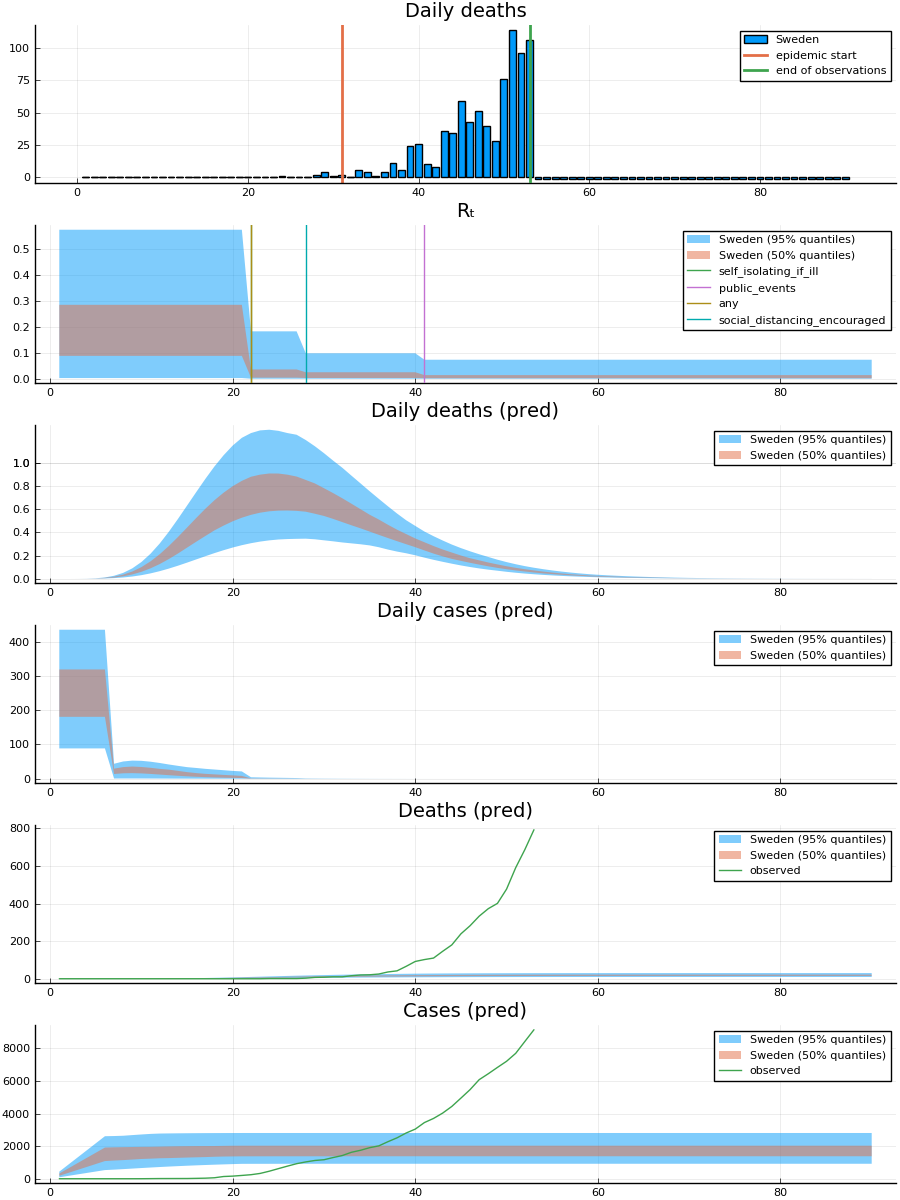

In [144]:
country_prediction_plot(10)

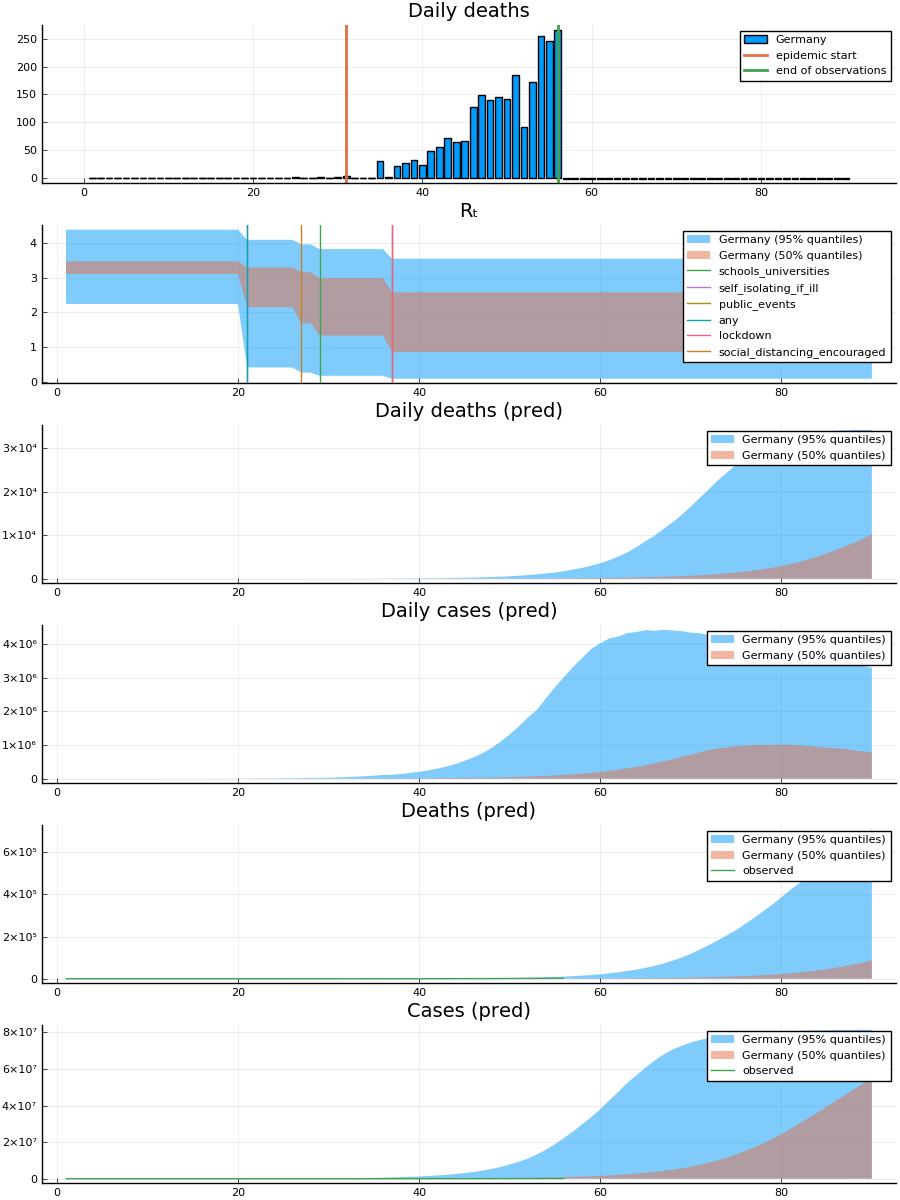

In [110]:
country_prediction_prior_plot(3)

# Comparing with Stan

In [33]:
using PyCall

In [145]:
using PyCall: pyimport
pystan = pyimport("pystan")

PyObject <module 'pystan' from '/var/home/tef30/.local/lib/python3.5/site-packages/pystan/__init__.py'>

In [146]:
using LibGit2

imperialdir() = projectdir("external", "covid19model")
imperialdir(args...) = projectdir("external", "covid19model", args...)

if !ispath(imperialdir())
    mkpath(projectdir("external"))
    LibGit2.clone("https://github.com/ImperialCollegeLondon/covid19model.git", imperialdir())
end

In [147]:
sm = pystan.StanModel(file=imperialdir("stan-models", "base.stan"))

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_26789167272cf46e6188fa9ce826678d NOW.


PyObject <pystan.model.StanModel object at 0x7fe002c949e8>

In [148]:
keys(rdata)

Base.KeySet for a Dict{String,Int64} with 17 entries. Keys:
  "SI"
  "deaths"
  "f"
  "covariate4"
  "covariate5"
  "pop"
  "x"
  "N0"
  "N2"
  "M"
  "N"
  "covariate3"
  "covariate2"
  "EpidemicStart"
  "covariate6"
  "cases"
  "covariate1"

In [149]:
d = Dict([(k, rdata[k]) for k in keys(rdata)]) # `values(df)` and `keys(df)` have different ordering so DON'T do `Dict(keys(df), values(df))`

Dict{String,Any} with 17 entries:
  "SI"            => [0.0183262, 0.0665923, 0.101914, 0.117717, 0.118386, 0.109…
  "deaths"        => [0 0 … 0 0; 0 0 … 0 0; … ; -1 -1 … -1 -1; -1 -1 … -1 -1]
  "f"             => [1.6332e-8 1.99194e-8 … 1.87614e-8 1.64636e-8; 3.29701e-7 …
  "covariate4"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "covariate5"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "pop"           => Int32[5792203, 60461828, 83783945, 46754783, 67886004, 652…
  "x"             => Any[]
  "N0"            => 6
  "N2"            => 90
  "M"             => 14
  "N"             => Int32[50, 75, 56, 62, 59, 64, 47, 53, 49, 53, 57, 50, 50, …
  "covariate3"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "covariate2"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 1.0 1.0 … 1.0 1…
  "EpidemicStart" => [31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31]
  "covariate6"    => [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 

In [150]:
fit_stan(n_iters=2_000) = sm.sampling(
    data=d, iter=n_iters, chains=1, warmup=100, algorithm="NUTS", 
    control=Dict(
        "adapt_delta" => 0.95,
        "max_treedepth" => 10
    )
)
f = fit_stan(300)


Gradient evaluation took 0.019414 seconds
1000 transitions using 10 leapfrog steps per transition would take 194.14 seconds.
Adjust your expectations accordingly!


         three stages of adaptation as currently configured.
         Reducing each adaptation stage to 15%/75%/10% of
         the given number of warmup iterations:
           init_buffer = 15
           adapt_window = 75
           term_buffer = 10

Iteration:   1 / 300 [  0%]  (Warmup)
Iteration:  30 / 300 [ 10%]  (Warmup)
Iteration:  60 / 300 [ 20%]  (Warmup)
Iteration:  90 / 300 [ 30%]  (Warmup)
Iteration: 101 / 300 [ 33%]  (Sampling)
Iteration: 130 / 300 [ 43%]  (Sampling)
Iteration: 160 / 300 [ 53%]  (Sampling)
Iteration: 190 / 300 [ 63%]  (Sampling)
Iteration: 220 / 300 [ 73%]  (Sampling)
Iteration: 250 / 300 [ 83%]  (Sampling)
Iteration: 280 / 300 [ 93%]  (Sampling)
Iteration: 300 / 300 [100%]  (Sampling)

 Elapsed Time: 464.598 seconds (Warm-up)
               1696.9 seconds (Sampling)
               2161.5 seco

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[1] is -inf, but must be > 0!  (in 'base.stan' at line 82)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
Exception: neg_binomial_2_lpmf: Location parameter[1] is -inf, but must be > 0!  (in 'base.stan' at line 82)

If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
but if this warning occurs often then your model may be either severely ill-conditioned or misspecified.

Informational Message: The current Metropolis proposal is about to be reject

PyObject 
For the full summary use 'print(fit)'

Inference for Stan model: anon_model_26789167272cf46e6188fa9ce826678d.
1 chains, each with iter=300; warmup=100; thin=1; 
post-warmup draws per chain=200, total post-warmup draws=200.

                   mean se_mean     sd    2.5%     25%     50%    75%  97.5%  n_eff   Rhat
mu[1]              3.82    0.04    0.6     2.7    3.38    3.78    4.2   5.12    238    1.0
mu[2]              3.46    0.03   0.21    2.98    3.32    3.45   3.62   3.89     49   0.99
mu[3]              4.63    0.07   0.54    3.69    4.26    4.57   5.03   5.72     70    1.0
mu[4]              4.53    0.02   0.33    3.92    4.31    4.52   4.71   5.21    200    1.0
mu[5]              4.01    0.02   0.31    3.55    3.79    3.94    4.2   4.67    233   1.01
mu[6]               4.7    0.02   0.28    4.16    4.51    4.72   4.89   5.26    176    1.0
mu[7]              3.43    0.04    0.6    2.31    2.98    3.44   3.82   4.59    229    1.0
mu[8]              5.79    0.05   0.67

In [151]:
la = f.extract(permuted=true)

Dict{Any,Any} with 15 entries:
  "E_deaths"    => [4.24592e-14 6.70734e-7 … 8.68543 8.44588; 2.6013e-14 4.2658…
  "ifr_noise"   => [0.967254 0.903304 … 1.10466 0.890114; 1.00411 1.19953 … 1.0…
  "tau"         => [77.9757, 36.5894, 53.9655, 62.814, 61.1647, 63.3454, 66.327…
  "Rt_adj"      => [3.92426 3.92426 … 0.814143 0.814081; 4.33059 4.33059 … 0.77…
  "mu"          => [3.92426 3.75131 … 3.27329 3.35448; 4.33059 3.45568 … 3.6320…
  "kappa"       => [0.859251, 1.58447, 1.43564, 0.974068, 0.833883, 0.605624, 0…
  "prediction"  => [42.4592 42.4592 … 431.009 418.916; 26.013 26.013 … 276.118 …
  "phi"         => [6.76716, 9.55064, 8.29775, 7.13862, 7.92892, 7.51676, 6.851…
  "alpha_hier"  => [0.402098 0.0278236 … 1.1741 1.42167e-10; 0.315784 0.0876068…
  "Rt"          => [3.92426 3.92426 … 0.828532 0.828532; 4.33059 4.33059 … 0.78…
  "y"           => [42.4592 39.3644 … 65.4664 131.575; 26.013 46.1167 … 40.3829…
  "alpha"       => [0.393966 0.0196919 … 1.16597 -0.00813169; 0.307652 0.07947

In [153]:
stan_chain = Chains(la["y"], ["y[$i]" for i = 1:size(la["y"], 2)])

Object of type Chains, with data of type 200×14×1 Array{Float64,3}

Iterations        = 1:200
Thinning interval = 1
Chains            = 1
Samples per chain = 200
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters      mean      std  naive_se    mcse       ess   r_hat
  ──────────  ────────  ───────  ────────  ──────  ────────  ──────
        y[1]   53.0353  36.5645    2.5855  1.4845  214.3982  0.9966
        y[2]   59.9878  24.1824    1.7100  1.9667  211.2771  1.0016
        y[3]   18.3795  10.4848    0.7414  0.4135  330.9355  0.9965
        y[4]   78.3496  33.4556    2.3657  7.4631  107.4759  1.0461
        y[5]   44.7802  18.5633    1.3126  3.3031  195.7131  1.0272
        y[6]   12.4206   5.0239    0.3552  0.5782   64.7393  1.0083
        y[7]   38.4220  26.8642    1.8996  1.4646  216.0476  0.9980
        y[8]   21.1069  11.6976    0.8271  1.3981  165.4770  1.

In [154]:
chain[:y]

Object of type Chains, with data of type 200×14×1 Array{Float64,3}

Iterations        = 1:200
Thinning interval = 1
Chains            = 1
Samples per chain = 200
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters      mean       std  naive_se     mcse       ess   r_hat
  ──────────  ────────  ────────  ────────  ───────  ────────  ──────
        y[1]  106.5155  100.4551    7.1032  11.8502  203.0244  1.0090
        y[2]   50.0889   16.2302    1.1476   0.2740  243.5274  0.9953
        y[3]  121.1581   42.7931    3.0259   0.7078  268.6056  0.9953
        y[4]   32.5631   10.9106    0.7715   0.0568  251.0328  0.9950
        y[5]   89.0113   21.5894    1.5266   0.6174  260.6146  0.9958
        y[6]   89.1963   23.0193    1.6277   0.9937  281.9326  0.9969
        y[7]  113.0131   88.0877    6.2287   4.9010  274.9854  0.9981
        y[8]   82.4601   26.3395    1.8625   

In [155]:
p1 = plot(stan_chain[:y]);

In [156]:
p2 = plot(chain[:y]);

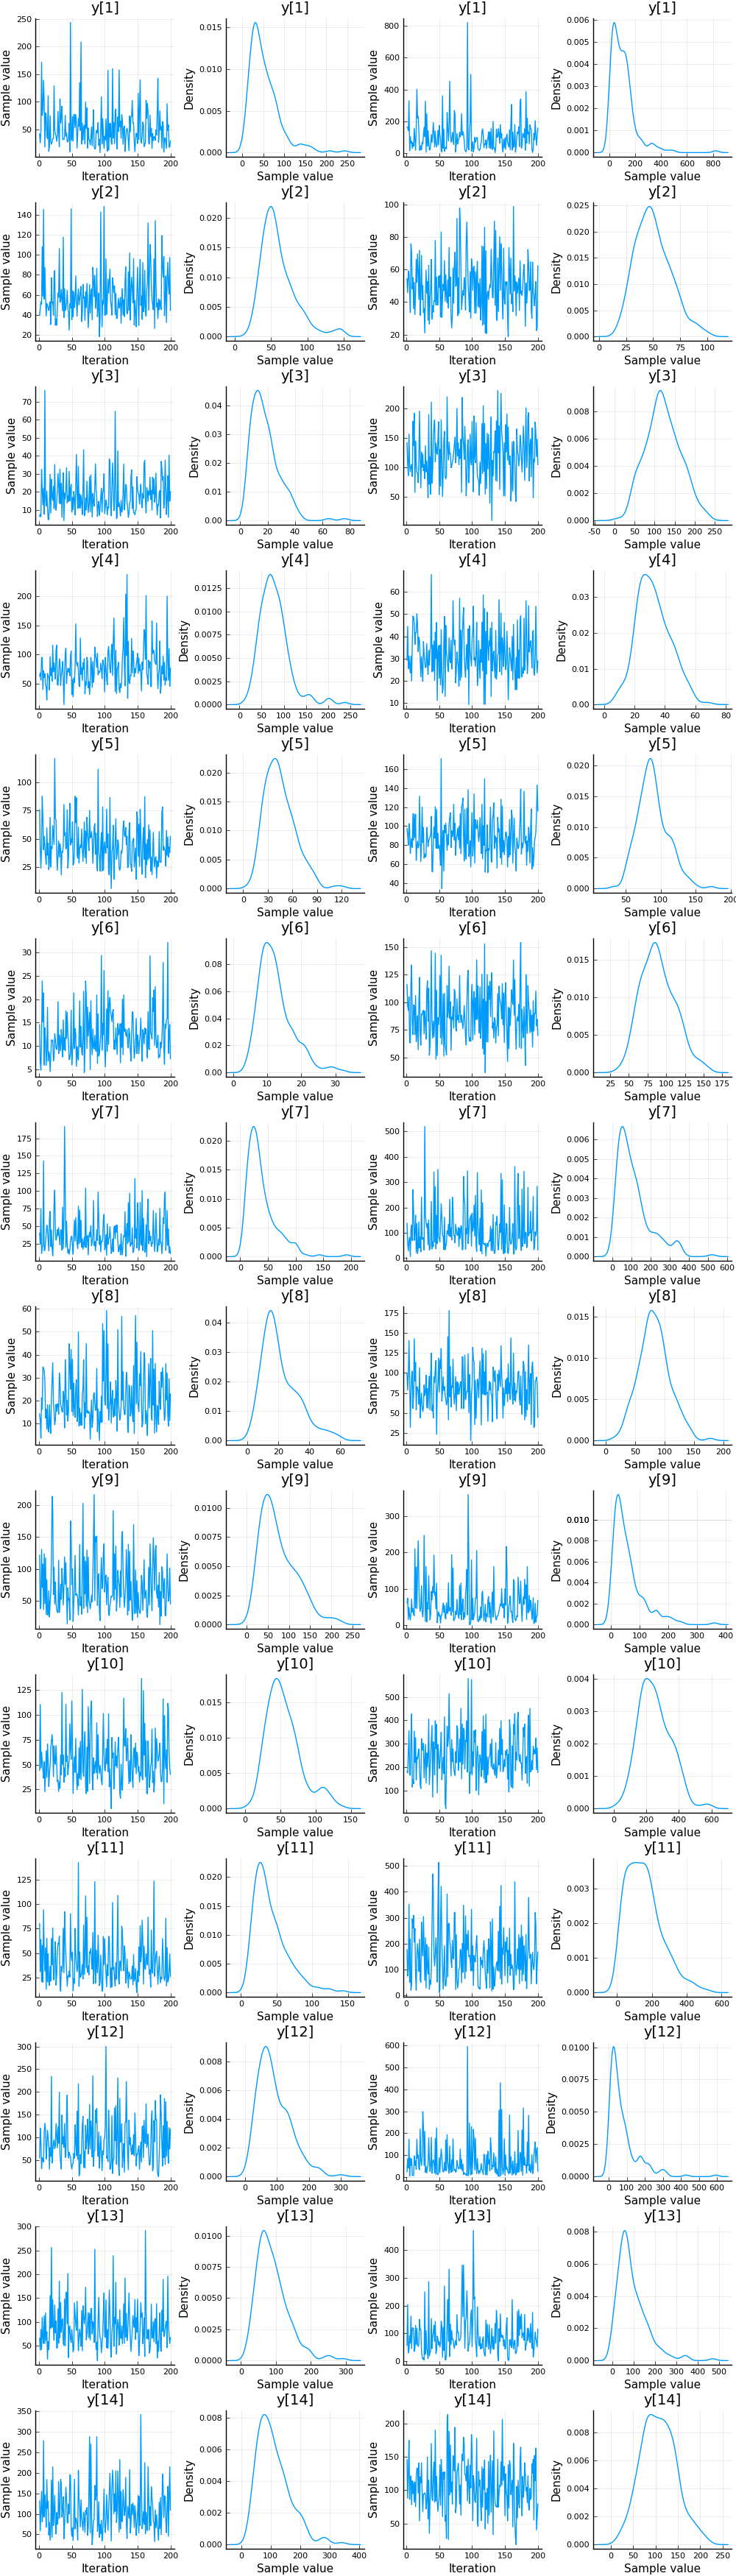

In [157]:
plot(p1, p2, layout = (1, 2))

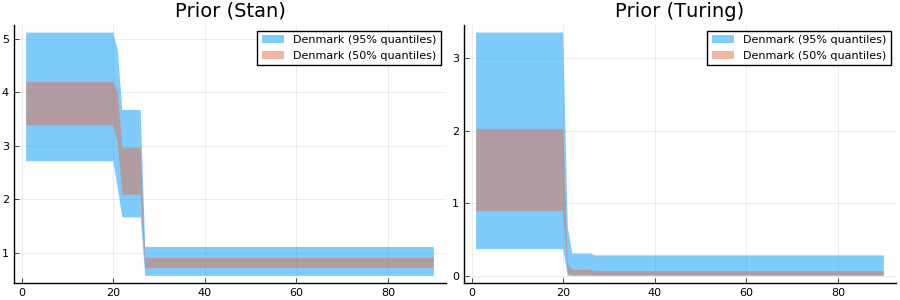

In [167]:
country_idx = 1

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

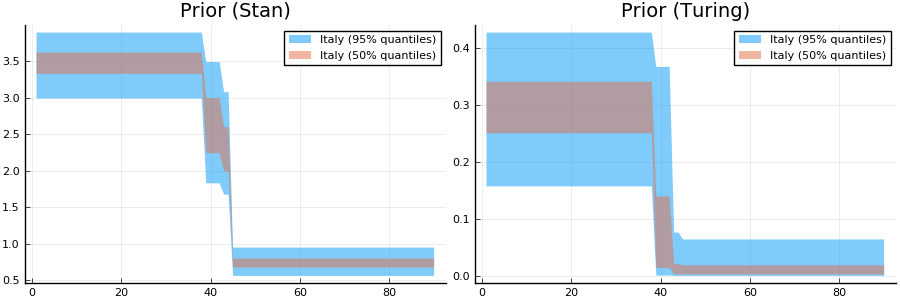

In [168]:
country_idx = 2

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

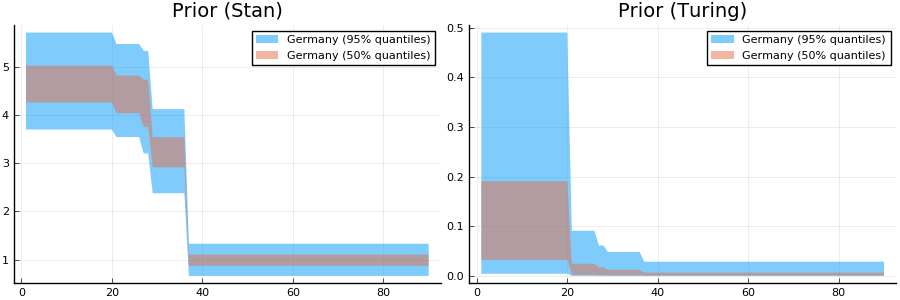

In [169]:
country_idx = 3

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

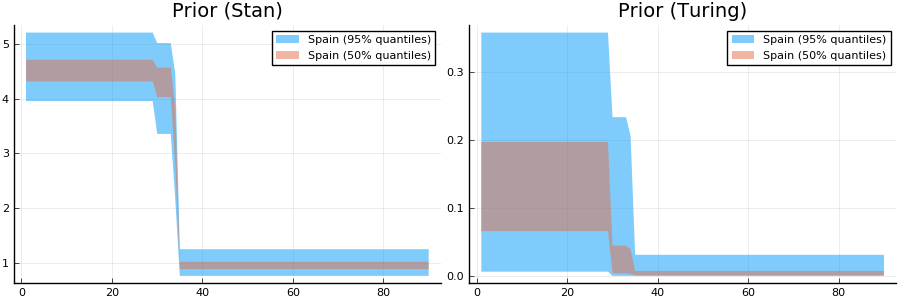

In [170]:
country_idx = 4

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

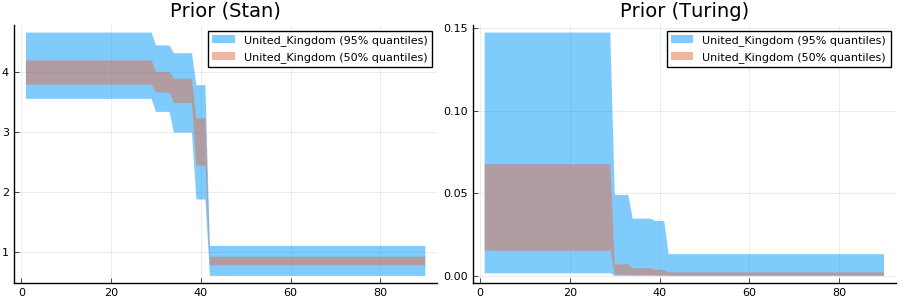

In [171]:
country_idx = 5

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

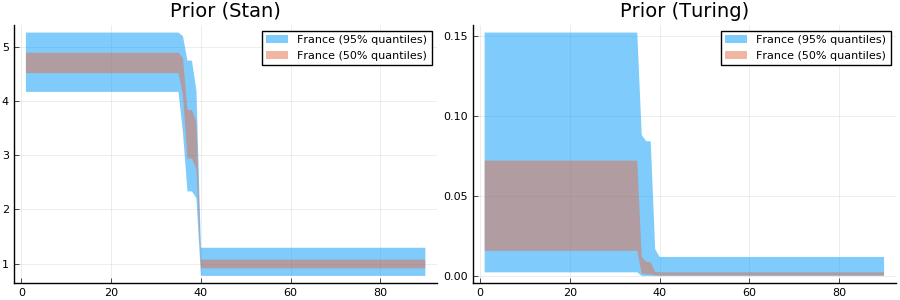

In [172]:
country_idx = 6

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

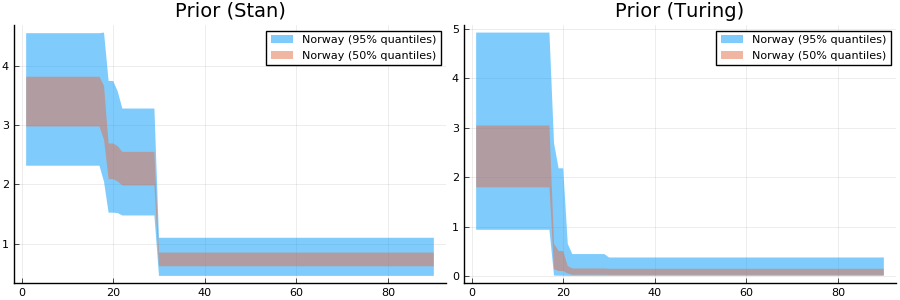

In [173]:
country_idx = 7

vals = la["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_chain[i][country_idx] for i = 1:length(chain)]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

## Sampling from the prior

This approach to sampling from the prior using Stan comes from https://betanalpha.github.io/assets/case_studies/principled_bayesian_workflow.html#step-four-build-a-model

In [ ]:
stan_prior_model_str = """
data {
  int <lower=1> M; // number of countries
  int <lower=1> N0; // number of days for which to impute infections
  int<lower=1> N[M]; // days of observed data for country m. each entry must be <= N2
  int<lower=1> N2; // days of observed data + # of days to forecast
  int cases[N2,M]; // reported cases
  int deaths[N2, M]; // reported deaths -- the rows with i > N contain -1 and should be ignored
  matrix[N2, M] f; // h * s
  matrix[N2, M] covariate1;
  matrix[N2, M] covariate2;
  matrix[N2, M] covariate3;
  matrix[N2, M] covariate4;
  matrix[N2, M] covariate5;
  matrix[N2, M] covariate6;
  int EpidemicStart[M];
  real pop[M];
  real SI[N2]; // fixed pre-calculated SI using emprical data from Neil
}

generated quantities {
  real<lower=0> mu[M]; // intercept for Rt
  real<lower=0> alpha_hier[6]; // sudo parameter for the hier term for alpha
  real<lower=0> kappa;
  real<lower=0> y[M];
  real<lower=0> phi;
  real<lower=0> tau;
  real<lower=0> ifr_noise[M];

  real alpha[6];
  matrix[N2, M] prediction = rep_matrix(0,N2,M);
  matrix[N2, M] E_deaths  = rep_matrix(0,N2,M);
  matrix[N2, M] Rt = rep_matrix(0,N2,M);
  matrix[N2, M] Rt_adj = Rt;

  matrix[N2, M] prediction0 = rep_matrix(0,N2,M);
  matrix[N2, M] E_deaths0  = rep_matrix(0,N2,M);

  tau = exponential_rng(0.03);
  for (m in 1:M){
    y[m] = exponential_rng(1/tau);
  }
  phi = fabs(normal_rng(0,5));
  kappa = fabs(normal_rng(0,0.5));
  for (m in 1:M) mu[m] = fabs(normal_rng(3.28, kappa)); // citation: https://academic.oup.com/jtm/article/27/2/taaa021/5735319
  for (i in 1:6) alpha_hier[i] = gamma_rng(.1667,1);
  for (m in 1:M) ifr_noise[m] = fabs(normal_rng(1,0.1));
    
  {
    matrix[N2,M] cumm_sum = rep_matrix(0,N2,M);
    for(i in 1:6){
      alpha[i] = alpha_hier[i] - ( log(1.05) / 6.0 );
    }
    for (m in 1:M){
      for (i in 2:N0){
        cumm_sum[i,m] = cumm_sum[i-1,m] + y[m]; 
      }
      prediction[1:N0,m] = rep_vector(y[m],N0); // learn the number of cases in the first N0 days
        
      Rt[,m] = mu[m] * exp( covariate1[,m] * (-alpha[1]) + covariate2[,m] * (-alpha[2]) +
                            covariate3[,m] * (-alpha[3]) + covariate4[,m] * (-alpha[4]) + covariate5[,m] * (-alpha[5]) + 
                            covariate6[,m] * (-alpha[6]) );
      Rt_adj[1:N0,m] = Rt[1:N0,m];
      for (i in (N0+1):N2) {
        real convolution=0;
        for(j in 1:(i-1)) {
          convolution += prediction[j, m] * SI[i-j];
        }
        cumm_sum[i,m] = cumm_sum[i-1,m] + prediction[i-1,m];
        Rt_adj[i,m] = ((pop[m]-cumm_sum[i,m]) / pop[m]) * Rt[i,m];
        prediction[i, m] = Rt_adj[i,m] * convolution;
      }
        
      E_deaths[1, m]= 1e-15 * prediction[1,m];
      for (i in 2:N2){
        for(j in 1:(i-1)){
          E_deaths[i,m] += prediction[j,m] * f[i-j,m] * ifr_noise[m];
        }
      }
    }
  }

  {
    matrix[N2,M] cumm_sum0 = rep_matrix(0,N2,M);
    for (m in 1:M){
      for (i in 2:N0){
        cumm_sum0[i,m] = cumm_sum0[i-1,m] + y[m]; 
      }
      prediction0[1:N0,m] = rep_vector(y[m],N0); 
      for (i in (N0+1):N2) {
        real convolution0 = 0;
        for(j in 1:(i-1)) {
          convolution0 += prediction0[j, m] * SI[i-j]; 
        }
        cumm_sum0[i,m] = cumm_sum0[i-1,m] + prediction0[i-1,m];
        prediction0[i, m] =  ((pop[m]-cumm_sum0[i,m]) / pop[m]) * mu[m] * convolution0;
      }
        
      E_deaths0[1, m] = uniform_rng(1e-16, 1e-15);
      for (i in 2:N2){
        for(j in 1:(i-1)){
          E_deaths0[i,m] += prediction0[j,m] * f[i-j,m] * ifr_noise[m];
        }
      }
    }
  }
}

""";

In [44]:
sm_prior = pystan.StanModel(model_code=stan_prior_model_str)

fit_stan_prior(n_iters=2_000) = sm_prior.sampling(
    # I believe `refresh` ensures that we 
    data=d, iter=n_iters, chains=1, warmup=0, algorithm="Fixed_param", refresh=n_iters
)

f_prior = fit_stan_prior(10000)

Iteration:    1 / 10000 [  0%]  (Sampling)
Iteration: 10000 / 10000 [100%]  (Sampling)

 Elapsed Time: 0 seconds (Warm-up)
               73.581 seconds (Sampling)
               73.581 seconds (Total)



INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_8f81a2e31bcfa3936009652c0191c457 NOW.


PyObject 
For the full summary use 'print(fit)'

Inference for Stan model: anon_model_8f81a2e31bcfa3936009652c0191c457.
1 chains, each with iter=10000; warmup=0; thin=1; 
post-warmup draws per chain=10000, total post-warmup draws=10000.

                   mean se_mean     sd    2.5%     25%    50%    75%  97.5%  n_eff   Rhat
mu[1]              3.28  4.9e-3   0.49     2.2     3.1   3.28   3.46   4.36  10055    1.0
mu[2]              3.27  5.0e-3   0.49    2.18    3.09   3.28   3.46   4.32   9691    1.0
mu[3]              3.29  5.0e-3   0.49    2.22     3.1   3.28   3.47   4.38   9888    1.0
mu[4]              3.28  4.8e-3   0.49    2.22     3.1   3.28   3.46   4.35  10197    1.0
mu[5]              3.28  4.8e-3   0.48    2.21    3.11   3.28   3.46   4.34  10100    1.0
mu[6]              3.28  4.8e-3   0.48    2.21     3.1   3.28   3.46   4.31   9977    1.0
mu[7]              3.28  5.0e-3    0.5    2.18     3.1   3.28   3.46   4.41  10079    1.0
mu[8]              3.28  5.0e-3    0.5    

In [50]:
la_prior = f_prior.extract(permuted=true)

Dict{Any,Any} with 15 entries:
  "E_deaths"    => [7.37994e-14 1.2936e-6 … 1284.6 1210.94; 5.62439e-15 9.90628…
  "ifr_noise"   => [1.07327 0.955612 … 0.947721 1.08559; 1.07844 0.972481 … 1.0…
  "tau"         => [56.4231, 37.3304, 14.203, 21.9346, 80.1116, 13.7805, 37.269…
  "Rt_adj"      => [3.31604 3.31604 … 0.228173 0.226854; 3.26911 3.26911 … 0.40…
  "mu"          => [3.31604 3.34936 … 2.97869 3.20564; 3.26911 3.3814 … 3.55722…
  "kappa"       => [0.134139, 0.161068, 0.0444869, 0.23877, 0.18354, 0.267094, …
  "prediction"  => [73.7994 73.7994 … 2923.3 2467.87; 5.62439 5.62439 … 0.02235…
  "phi"         => [6.30499, 4.77695, 6.35837, 3.57867, 6.16154, 4.89294, 4.015…
  "alpha_hier"  => [0.000137647 0.00109603 … 0.17616 6.72778e-6; 0.089396 0.010…
  "Rt"          => [3.31604 3.31604 … 2.61321 2.61321; 3.26911 3.26911 … 0.4015…
  "y"           => [73.7994 67.6098 … 39.0609 67.3577; 5.62439 87.7532 … 33.426…
  "alpha"       => [-0.00799405 -0.00703566 … 0.168028 -0.00812497; 0.0812643 

In [51]:
mean_Rₜ_stan = mean(la_prior["Rt"]; dims = 1)[1, :, :]

90×14 Array{Float64,2}:
 3.28056  3.27101  3.28655  3.28231  …  3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231  …  3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231  …  3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 3.28056  3.27101  3.28655  3.28231     3.28496  3.27139  3.27829  3.28425
 

In [111]:
res = generated_quantities(m, chain_prior)
prediction_prior = [x[1] for x in res];
expected_deaths_prior = [x[2] for x in res];
Rₜ_prior = [x[3] for x in res];

In [112]:
mean_Rₜ_turing = mean([hcat(Rₜ_prior[i]...) for i = 1:length(Rₜ_prior)])

90×14 Array{Float64,2}:
 3.28994  3.2854   3.28474  3.27304  …  3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304  …  3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304  …  3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 3.28994  3.2854   3.28474  3.27304     3.27679  3.27177  3.28155  3.2835 
 

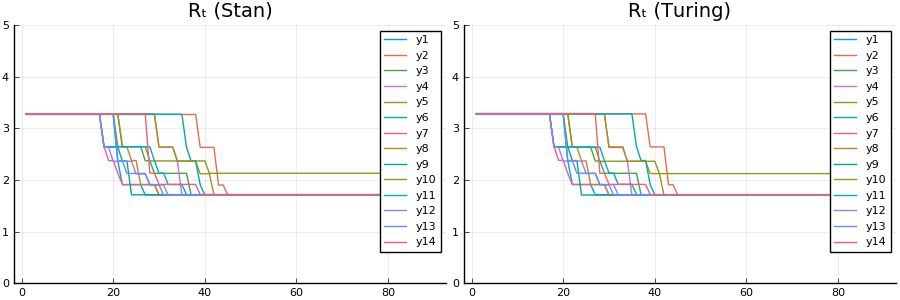

In [54]:
p1 = plot(mean_Rₜ_stan)
title!("Rₜ (Stan)")

p2 = plot(mean_Rₜ_turing)
title!("Rₜ (Turing)")

plot(p1, p2, size = (900, 300))
ylims!(0, 5)

In [55]:
stan_prior_chain = Chains(la_prior["y"], ["y[$i]" for i = 1:size(la_prior["y"], 2)])

Object of type Chains, with data of type 10000×14×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = y[1], y[2], y[3], y[4], y[5], y[6], y[7], y[8], y[9], y[10], y[11], y[12], y[13], y[14]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters     mean      std  naive_se    mcse         ess   r_hat
  ──────────  ───────  ───────  ────────  ──────  ──────────  ──────
        y[1]  33.1602  57.5914    0.5759  0.5924  10086.8333  1.0000
        y[2]  33.9888  57.9839    0.5798  0.5339  10048.8931  0.9999
        y[3]  34.1110  58.4224    0.5842  0.5517  10626.2427  0.9999
        y[4]  33.5988  57.6608    0.5766  0.5953  10146.5594  1.0005
        y[5]  33.6832  55.4417    0.5544  0.6005  10222.6921  0.9999
        y[6]  33.7919  57.2028    0.5720  0.5679  10033.8224  0.9999
        y[7]  33.0874  57.2928    0.5729  0.5454  10057.5141  0.9999
        y[8]  33.5144  56.0458    0.5605  0.6160

In [117]:
p1 = plot(stan_prior_chain[:y]);

In [118]:
p2 = plot(chain_prior[:y]);

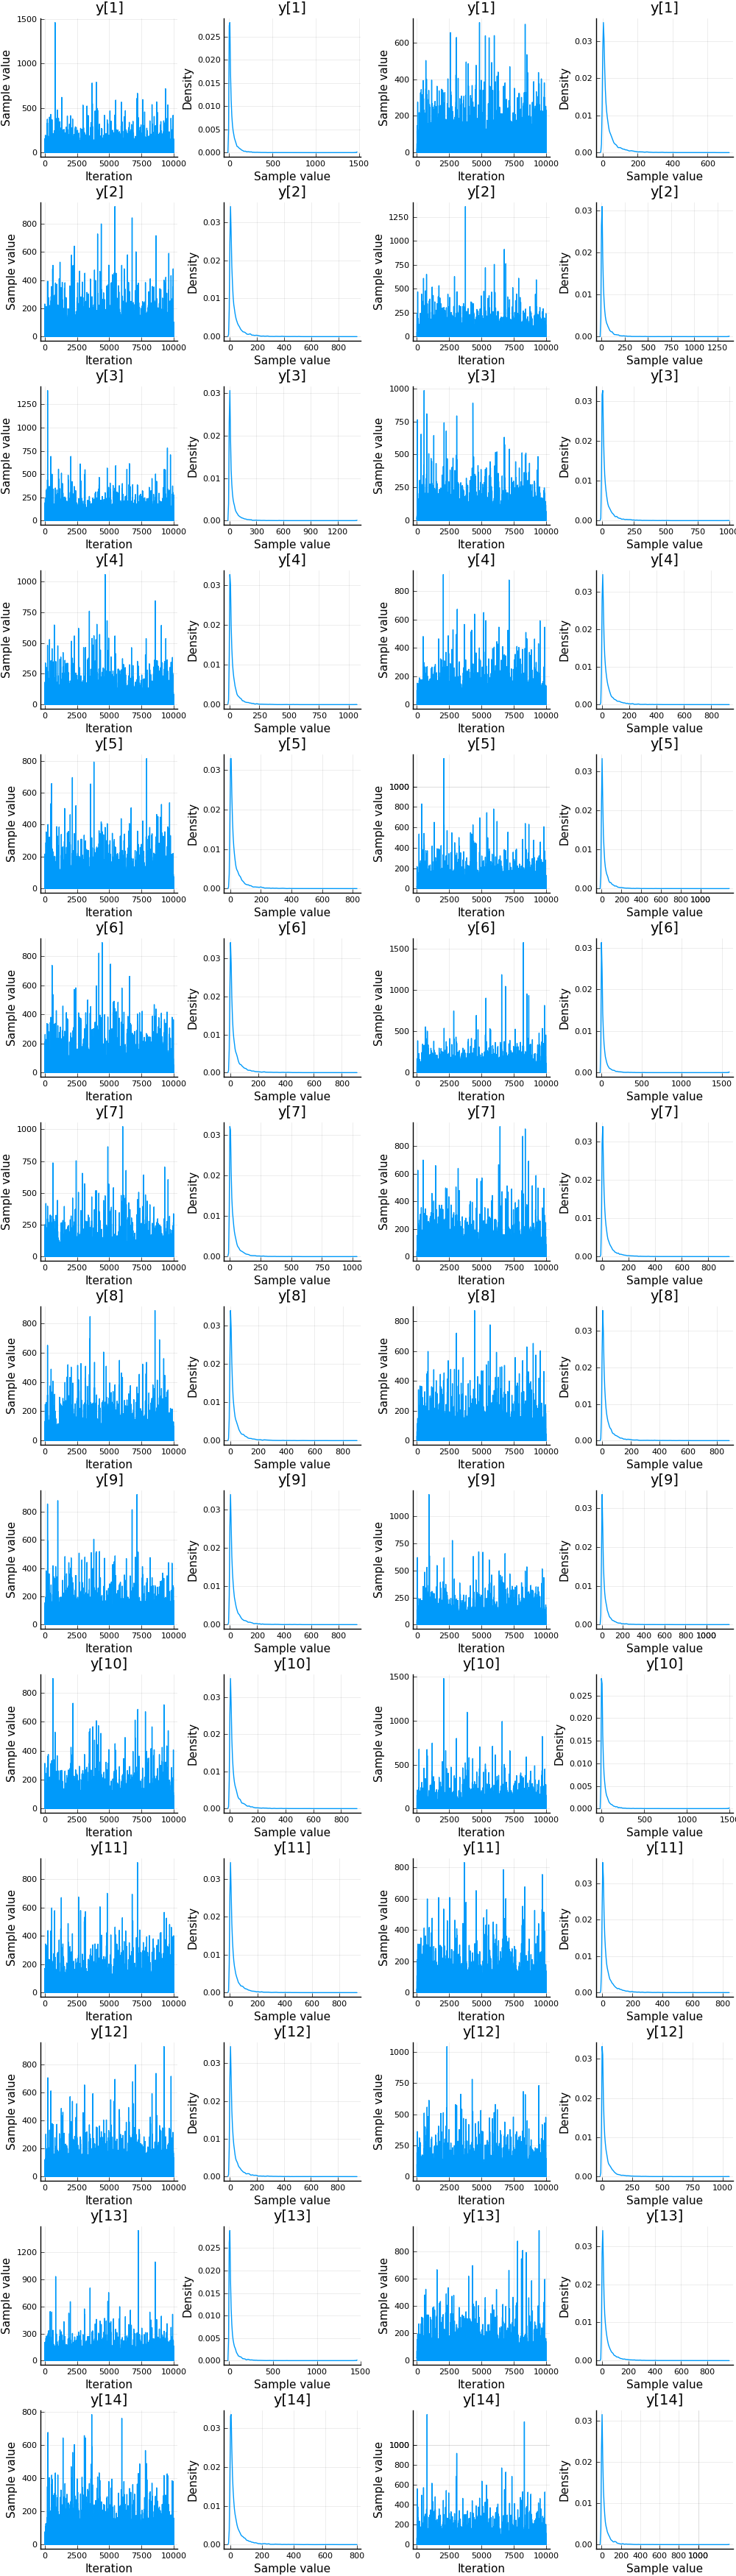

In [119]:
plot(p1, p2, layout = (1, 2))

In [120]:
country_idx = 7

7

In [121]:
hcat([Rₜ_prior[i][country_idx] for i = 1:10_000]...)'

10000×90 LinearAlgebra.Adjoint{Float64,Array{Float64,2}}:
 3.22121  3.22121  3.22121  3.22121  …  1.73284    1.73284    1.73284  
 3.00377  3.00377  3.00377  3.00377     0.786548   0.786548   0.786548 
 4.37341  4.37341  4.37341  4.37341     1.11472    1.11472    1.11472  
 3.2794   3.2794   3.2794   3.2794      2.84284    2.84284    2.84284  
 3.35461  3.35461  3.35461  3.35461     3.39577    3.39577    3.39577  
 3.29815  3.29815  3.29815  3.29815  …  0.828864   0.828864   0.828864 
 3.37404  3.37404  3.37404  3.37404     0.814505   0.814505   0.814505 
 3.14304  3.14304  3.14304  3.14304     2.41257    2.41257    2.41257  
 3.07687  3.07687  3.07687  3.07687     0.582668   0.582668   0.582668 
 3.92673  3.92673  3.92673  3.92673     1.71446    1.71446    1.71446  
 3.2338   3.2338   3.2338   3.2338   …  1.62845    1.62845    1.62845  
 3.62122  3.62122  3.62122  3.62122     1.19621    1.19621    1.19621  
 2.42754  2.42754  2.42754  2.42754     1.55093    1.55093    1.55093  
 ⋮    

In [122]:
la_prior["Rt"][:, :, country_idx]

10000×90 Array{Float64,2}:
 3.14101  3.14101  3.14101  3.14101  3.14101  …  2.47527   2.47527   2.47527 
 3.4553   3.4553   3.4553   3.4553   3.4553      0.424401  0.424401  0.424401
 3.23365  3.23365  3.23365  3.23365  3.23365     0.036031  0.036031  0.036031
 3.31529  3.31529  3.31529  3.31529  3.31529     2.69828   2.69828   2.69828 
 3.72362  3.72362  3.72362  3.72362  3.72362     3.48318   3.48318   3.48318 
 2.92966  2.92966  2.92966  2.92966  2.92966  …  2.27289   2.27289   2.27289 
 2.87392  2.87392  2.87392  2.87392  2.87392     1.50847   1.50847   1.50847 
 3.36349  3.36349  3.36349  3.36349  3.36349     2.25093   2.25093   2.25093 
 3.2871   3.2871   3.2871   3.2871   3.2871      1.82832   1.82832   1.82832 
 2.89423  2.89423  2.89423  2.89423  2.89423     1.56234   1.56234   1.56234 
 3.5434   3.5434   3.5434   3.5434   3.5434   …  0.527603  0.527603  0.527603
 4.65345  4.65345  4.65345  4.65345  4.65345     4.79497   4.79497   4.79497 
 3.35794  3.35794  3.35794  3.35794  

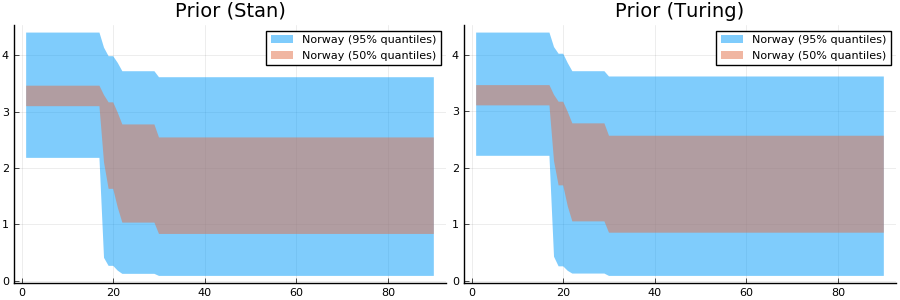

In [123]:
vals = la_prior["Rt"][:, :, country_idx]'
p1 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Stan)")

vals = hcat([Rₜ_prior[i][country_idx] for i = 1:10_000]...)
p2 = plot_confidence(vals; label = "$(countries[country_idx])")
title!("Prior (Turing)")

plot(p1, p2; layout = (1, 2), size = (900, 300))

In [124]:
stan_chain_alpha_hier = Chains(la_prior["alpha_hier"], ["α_hier[$i]" for i = 1:6])

Object of type Chains, with data of type 10000×6×1 Array{Float64,3}

Iterations        = 1:10000
Thinning interval = 1
Chains            = 1
Samples per chain = 10000
parameters        = α_hier[1], α_hier[2], α_hier[3], α_hier[4], α_hier[5], α_hier[6]

2-element Array{ChainDataFrame,1}

Summary Statistics
  parameters    mean     std  naive_se    mcse         ess   r_hat
  ──────────  ──────  ──────  ────────  ──────  ──────────  ──────
   α_hier[1]  0.1646  0.3973    0.0040  0.0043  10010.8911  0.9999
   α_hier[2]  0.1647  0.3970    0.0040  0.0036  10073.2644  0.9999
   α_hier[3]  0.1668  0.4078    0.0041  0.0038  10405.9857  1.0000
   α_hier[4]  0.1695  0.4107    0.0041  0.0043  10187.6807  0.9999
   α_hier[5]  0.1668  0.4053    0.0041  0.0038  10631.0784  0.9999
   α_hier[6]  0.1665  0.4016    0.0040  0.0040  10133.3003  0.9999

Quantiles
  parameters    2.5%   25.0%   50.0%   75.0%   97.5%
  ──────────  ──────  ──────  ──────  ──────  ──────
   α_hier[1]  0.0000  0.0001  0.0097  0.

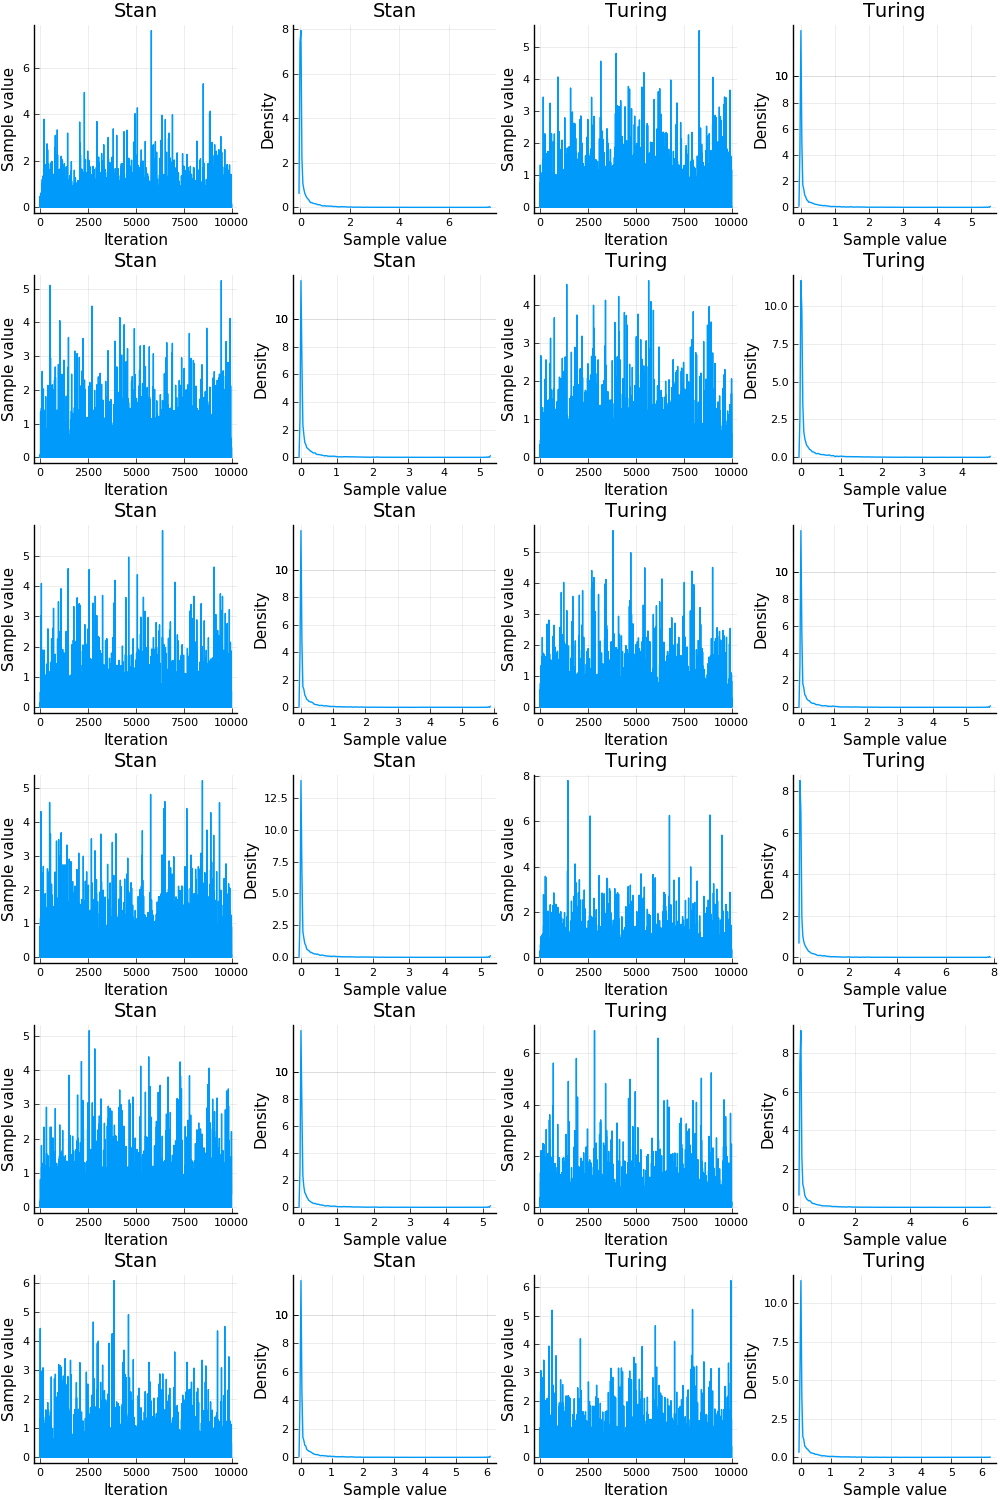

In [125]:
p1 = plot(stan_chain_alpha_hier[:α_hier])
title!("Stan")
p2 = plot(chain_prior[:α_hier])
title!("Turing")

plot(p1, p2, layout = (1, 2))